# Leaky integrate and fire

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import brian2 as b

## Neurons

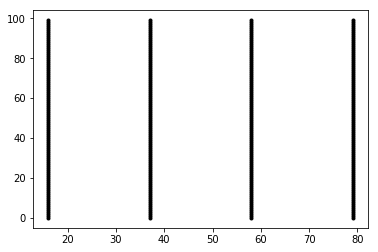

In [5]:
b.start_scope()

N = 100
tau_membrane = 10 * b.ms
equations = '''
dv/dt = (1 - v) / tau_membrane : 1 (unless refractory)
'''

neuron_group = b.NeuronGroup( N, equations,
                              threshold = 'v > 0.8',
                              reset = 'v = 0',
                              refractory = 5 * b.ms,
                              method = 'euler' )

state_monitor = b.StateMonitor( neuron_group, 'v', record = 0 )
spike_monitor = b.SpikeMonitor( neuron_group )

b.run( 100 * b.ms )

plt.plot( spike_monitor.t / b.ms, spike_monitor.i, 'k.' )

## Synapses

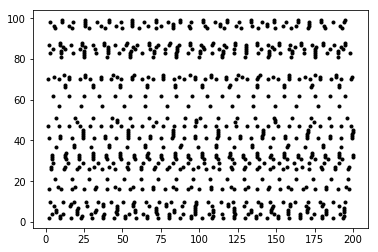

In [18]:
b.start_scope()

N = 100
tau_membrane = 10 * b.ms
equations = '''
dv/dt = (I - v) / tau_membrane : 1 (unless refractory)
I : 1
'''

neuron_group = b.NeuronGroup( N, equations,
                              threshold = 'v > 0.8',
                              reset = 'v = 0',
                              refractory = 5 * b.ms,
                              method = 'euler' )
neuron_group.I = np.random.exponential( size = (N,) )

synapses = b.Synapses( neuron_group, neuron_group,
                       on_pre = 'v_post += 0.3' )

for i in range( N - 1 ):
    synapses.connect( i = i, j = i + 1 )

state_monitor = b.StateMonitor( neuron_group, 'v', record = True )
spike_monitor = b.SpikeMonitor( neuron_group )

b.run( 200 * b.ms )

plt.plot( spike_monitor.t / b.ms, spike_monitor.i, 'k.' )

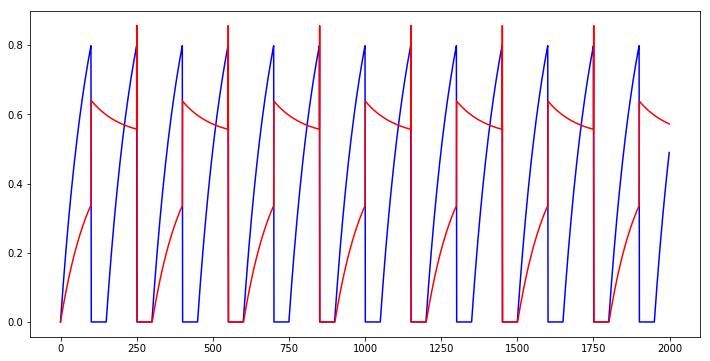

In [23]:
plt.figure( figsize = (12, 6) )
plt.plot( state_monitor.v[81, :], 'b-' )
plt.plot( state_monitor.v[82, :], 'r-' )

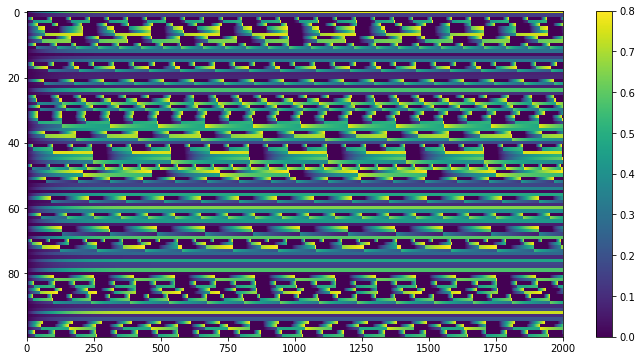

In [20]:
plt.figure( figsize = (12, 6) )
plt.imshow( state_monitor.v, aspect = 'auto' )
plt.clim( 0., 0.8 )
plt.colorbar()

## STDP

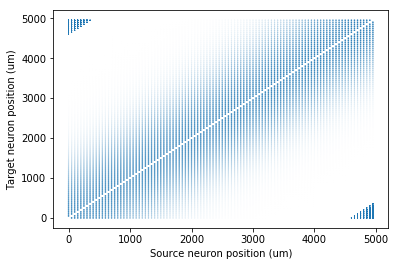

In [32]:
b.start_scope()

N = 100

tau_membrane = 10 * b.ms
tau_pre_synapse = 20 * b.ms
tau_post_synapse = 20 * b.ms

w_max = 0.02
Apre = -0.002
Apost = -Apre * ( tau_pre_synapse / tau_post_synapse ) * 0.95 # 1.05

neuron_spacing = 50 * b.umeter
total_width = (N / 8.) * neuron_spacing

neuron_equations = '''
dv/dt = (I - v) / tau_membrane : 1 (unless refractory)
I : 1
x : meter
'''

neuron_group = b.NeuronGroup( N, neuron_equations,
                              threshold = 'v > 0.8',
                              reset = 'v = 0',
                              refractory = 5 * b.ms,
                              method = 'euler' )
neuron_group.I = np.random.exponential( size = (N,) ) * 1.
neuron_group.x = 'i * neuron_spacing'

synapse_equations = '''
w : 1
dapre/dt = -apre / tau_pre_synapse : 1 (event-driven)
dapost/dt = -apost / tau_post_synapse : 1 (event-driven)
'''
synapse_on_pre = '''
v_post += w
apre += Apre
w = clip( w + apost, 0, w_max)
'''
synapse_on_post = '''
apost += Apost
w = clip( w + apre, 0, w_max)
'''

synapses = b.Synapses( neuron_group, neuron_group, synapse_equations,
                       on_pre = synapse_on_pre,
                       on_post = synapse_on_post )

synapses.connect( condition = 'i != j' )
synapses.w = 'w_max * exp( -( x_pre - x_post ) ** 2 / ( 2 * total_width ** 2 ) )'

plt.scatter( synapses.x_pre/b.um, synapses.x_post/b.um, synapses.w*20)
plt.xlabel('Source neuron position (um)')
plt.ylabel('Target neuron position (um)');

state_monitor = b.StateMonitor( neuron_group, 'v', record = True )
spike_monitor = b.SpikeMonitor( neuron_group, variables = 'v' )

# synapse_monitor = b.StateMonitor( synapses, ['w', 'i', 'j'], record = True )

b.run( 2000 * b.ms )

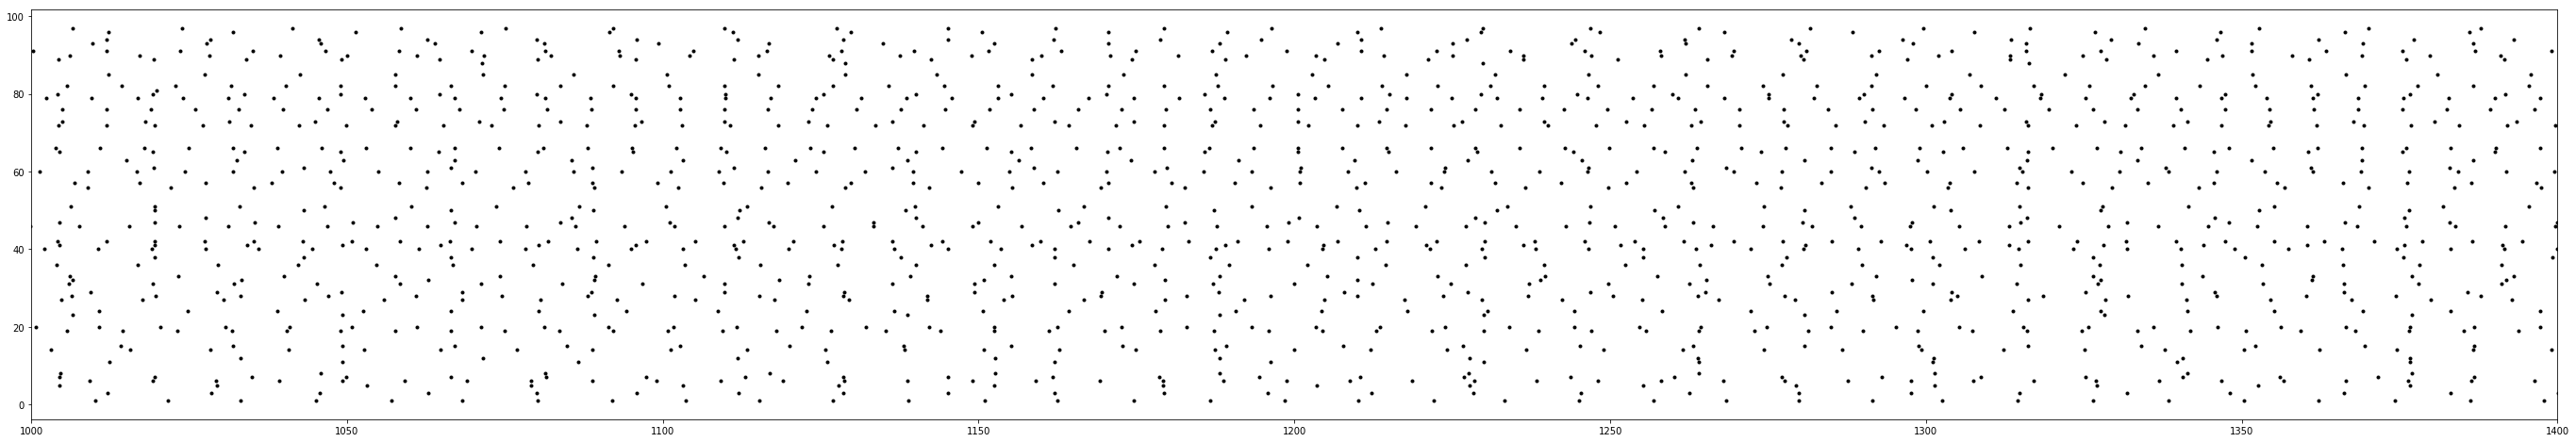

In [35]:
plt.figure( figsize = (48, 8) )
plt.plot( spike_monitor.t / b.ms, spike_monitor.i, 'k.' )
plt.xlim( 1000, 1400 )
plt.show()

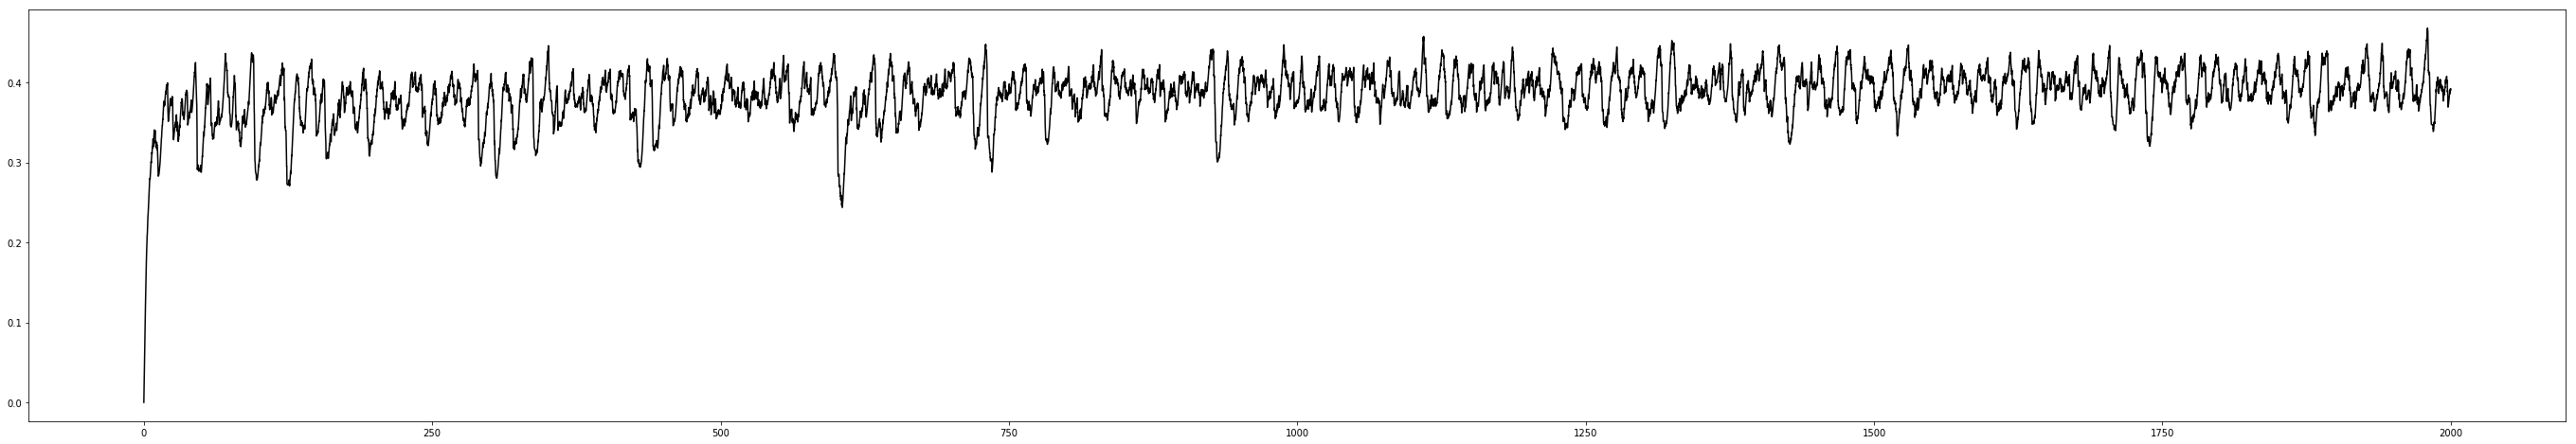

In [36]:
plt.figure( figsize = (48, 8) )
plt.plot( state_monitor.t / b.ms, np.mean( state_monitor.v, axis = 0 ), 'k-' )

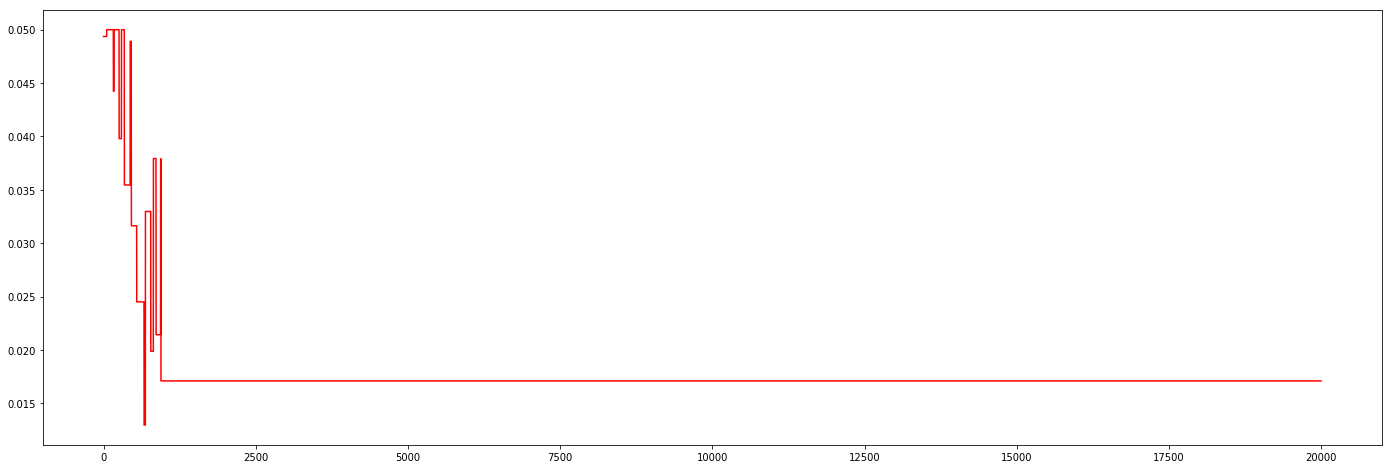

In [11]:
synapse_i =  synapse_monitor.i[:, 0]
synapse_j = synapse_monitor.j[:, 0]

plt.figure( figsize = (24, 8) )
plt.plot( synapse_monitor.w[1001, :], 'r-' )

In [6]:
import gc
gc.collect()

2196

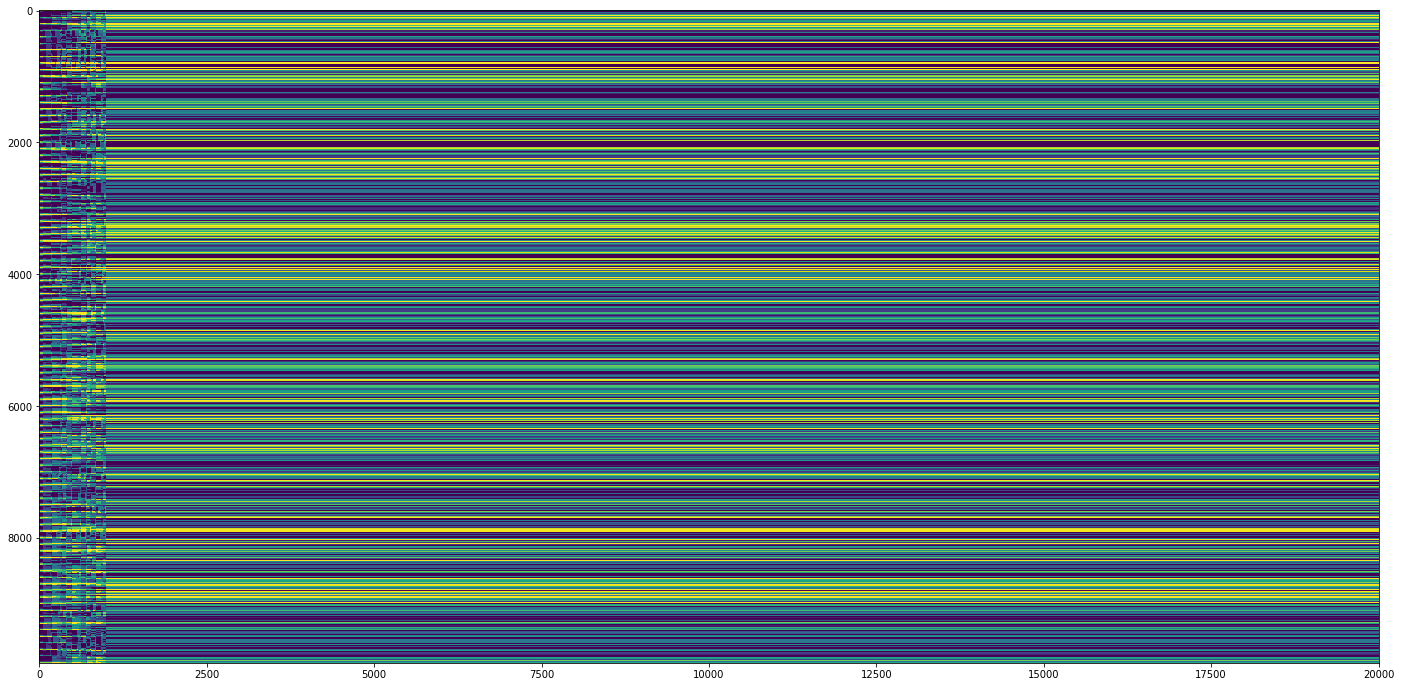

In [7]:
plt.figure( figsize = (24, 12) )
plt.imshow( synapse_monitor.w, aspect = 'auto' )
plt.clim( 0, 0.05 )

In [8]:
import gc
gc.collect()

2260

## Astrocytes

In [2]:
N = 400
Ni = N // 4

# conduction_velocity = 40 * (b.meter / b.second)

# neuron_density = 159457 * (1. / b.mm2)
neuron_density = 40000 * (1. / b.mm2)
fov_area = (N + Ni) / neuron_density
total_width = np.sqrt( fov_area )
total_height = np.sqrt( fov_area )

conduction_velocity = total_width / (20 * b.ms)
synaptic_delay_min = 0.4 * b.ms
synaptic_delay_max = 1.5 * b.ms

astrocyte_territory_area = 3151 * b.um2
Na = int( np.ceil( fov_area / astrocyte_territory_area ) )

print( 'FOV: {0:0.1f} um2'.format( fov_area / b.um2 ) )
print( '    ({0:0.1f} um by {1:0.1f} um)'.format( total_width / b.um, total_height / b.um ) )
print( 'Astrocytes: {0}'.format( Na ) )
print( 'Conduction velocity: {0} m/s'.format( conduction_velocity / (b.meter / b.second) ) )

FOV: 12500.0 um2
    (111.8 um by 111.8 um)
Astrocytes: 4
Conduction velocity: 0.005590169943749474 m/s


In [3]:
b.start_scope()

# neuron_spacing = 50 * b.um
# total_width = neuron_spacing * Nx
# total_height = neuron_spacing * Ny
# Nx = 30
# Ny = 30
# N = Nx * Ny

# Na = N // 2

print( 'Setting up input...', end = '' )
N_input = N * 10
N_input_interneurons = Ni * 10
inputs = b.PoissonGroup( N_input, 40 * b.Hz )
inputs_interneurons = b.PoissonGroup( N_input_interneurons, 110 * b.Hz )
print( 'Done' )

print( 'Setting up neurons...', end = '' )

tau_membrane = 10 * b.ms # 10
I_baseline = np.zeros( (1, (N + Ni)) )
# neuron_input = b.TimedArray( I_baseline, dt = 100 * b.second )
equations = '''
dv/dt = (I - v) / tau_membrane : 1 (unless refractory)
I : 1
refr : second
x : meter
y : meter
'''
neurons = b.NeuronGroup( N + Ni, equations,
                         threshold = 'v > 0.8',
                         reset = 'v = 0',
                         refractory = 'refr',
                         method = 'rk4' )
# neurons.I = np.random.exponential( size = (N,) ) * 2.
neurons.I = 0
neuron_refractory = np.zeros( (N + Ni,) )
neuron_refractory[:N] = 5
neuron_refractory[N:] = 1
neurons.refr = neuron_refractory * b.ms
# for i_x in range( Nx ):
#     for i_y in range( Ny ):
#         i_cur = i_x + (i_y * Ny)
#         neurons.x[i_cur] = neuron_spacing * i_x
#         neurons.y[i_cur] = neuron_spacing * i_y
neurons.x = np.random.rand( N + Ni ) * total_width
neurons.y = np.random.rand( N + Ni ) * total_height

neurons_e = neurons[:N]
neurons_i = neurons[N:]

# TODO Here!

print( 'Done' )

print( 'Setting up input connectivity...', end = '' )
w_input = 0.05
p_input = 0.05
input_synapses = b.Synapses( inputs, neurons_e, on_pre = 'v_post += w_input' )
input_synapses.connect( p = p_input )
input_synapses_interneurons = b.Synapses( inputs_interneurons, neurons_i, on_pre = 'v_post += w_input' )
input_synapses_interneurons.connect( p = p_input )
print( 'Done' )

print( 'Setting up astrocytes...', end = '' )

tau_mean_field = 10 * b.ms
tau_astrocyte = 1000 * b.ms
astrocyte_equations = '''
abar : 1
da/dt = ((abar - a) / tau_mean_field) - (a / tau_astrocyte) : 1
x : meter
y : meter
'''
astrocytes = b.NeuronGroup( Na, astrocyte_equations,
                            method = 'rk4' )
astrocytes.x = np.random.rand( Na ) * total_width
astrocytes.y = np.random.rand( Na ) * total_height

print( 'Done' )

print( 'Setting up astrocyte syncytium...', end = '' )
syncytium_equations = '''
abar_post = (1 / Na) * a_pre (summed)
'''
syncytium = b.Synapses( astrocytes, astrocytes )
syncytium.connect()
print( 'Done' )

print( 'Setting up excitatory synapses...' )

synapse_connect_p = 0.1
synapse_connect_p_i = 0.125
synapse_r_max = 6 * b.um
tau_astro_synapse = 100 * b.ms
tau_pre_synapse = 20 * b.ms
tau_post_synapse = 20 * b.ms
w_max = 0.1
Apre = 0.01 # -0.01
Apost = -Apre * ( tau_pre_synapse / tau_post_synapse ) * 1.05 # 0.95 # 1.05
atot_threshold = 2.0
atot_scale = 1.0
synapse_equations = '''
atot : 1
datotint/dt = (atot - atotint) / tau_astro_synapse : 1 (clock-driven)
w : 1
dapre/dt = -apre / tau_pre_synapse : 1 (event-driven)
dapost/dt = -apost / tau_post_synapse : 1 (event-driven)
i_ast : integer
x_syn : meter
y_syn : meter
'''
# datot_int/dt = (atot - atot_int) / tau_astro_synapse : 1 (clock-driven)
# dw/dt = 0 / tau_astro_synapse : 1
# w_expressed = (0.5 * (tanh( (atot_threshold - atot_int) / atot_scale ) + 1)) * w : 1

plasticity_on = 1
synapse_on_pre = '''
v_post += w
apre += Apre
w = clip( w + plasticity_on * apost, 0, w_max )
'''
synapse_on_post = '''
apost += Apost
w = clip( w + plasticity_on * apre, 0, w_max )
'''

ast_x = astrocytes.x
ast_y = astrocytes.y
astrocyte_pre_neurons = [ [] for i_ast in range( Na ) ]
astrocyte_synapses_e = [ [] for i_ast in range( Na ) ]
astrocyte_synapses_i = [ [] for i_ast in range( Na ) ]

synapses_e = b.Synapses( neurons_e, neurons, synapse_equations,
                         on_pre = synapse_on_pre,
                         on_post = synapse_on_post,
                         method = 'rk4' )
synapses_e.connect( condition = 'i != j', p = synapse_connect_p )
synapses_e.w = 0. # w_max
print( '    Starting processing of {0} synapses'.format( synapses_e.N ) )
for i_synapse, i in enumerate( synapses_e.i ):
    if i_synapse > 0 and i_synapse % 100 == 0:
        print( '        Excitatory synapse {0}'.format( i_synapse ) )
    r_cur = synapse_r_max * np.random.rand()
    theta_cur = 2 * np.pi * np.random.rand()
    cur_syn_x = synapses_e.x_post[i_synapse] + r_cur * np.cos( theta_cur )
    cur_syn_y = synapses_e.y_post[i_synapse] + r_cur * np.sin( theta_cur )
    
    synapses_e.x_syn[i_synapse] = cur_syn_x
    synapses_e.y_syn[i_synapse] = cur_syn_y
    v_cur = np.array( [cur_syn_x, cur_syn_y] )
    
    cur_conduction_delay = np.sqrt( (cur_syn_x - synapses_e.x_pre[i_synapse]) ** 2 + (cur_syn_y - synapses_e.y_pre[i_synapse]) ** 2) / conduction_velocity
    cur_synaptic_delay = synaptic_delay_min + np.random.rand() * (synaptic_delay_max - synaptic_delay_min)
    synapses_e.delay[i_synapse] = cur_conduction_delay + cur_synaptic_delay
    
    astrocyte_distances = np.zeros( (Na,) )
    for i_ast in range( Na ):
        v_ast = np.array( [ast_x[i_ast], ast_y[i_ast]] )
        astrocyte_distances[i_ast] = np.linalg.norm( v_ast - v_cur )
    i_ast_cur = np.argmin( astrocyte_distances )
    synapses_e.i_ast[i_synapse] = i_ast_cur
    
    astrocyte_pre_neurons[i_ast_cur].append( i )
    astrocyte_synapses_e[i_ast_cur].append( i_synapse )


print( 'Setting up inhibitory synapses...' )
    
w_i = -0.1
synapse_i_equations = '''
atot : 1
w = w_i : 1
i_ast : integer
x_syn : meter
y_syn : meter
'''
synapse_i_on_pre = '''
v_post += w
'''
    
synapses_i = b.Synapses( neurons_i, neurons_e, synapse_i_equations,
                         on_pre = synapse_i_on_pre )
synapses_i.connect( p = synapse_connect_p_i )
# synapses_i.w = w_i
print( '    Starting processing of {0} synapses'.format( synapses_i.N ) )
for i_synapse, i in enumerate( synapses_i.i ):
    if i_synapse > 0 and i_synapse % 100 == 0:
        print( '        Inhibitory synapse {0}'.format( i_synapse ) )
    r_cur = synapse_r_max * np.random.rand()
    theta_cur = 2 * np.pi * np.random.rand()
    cur_syn_x = synapses_i.x_post[i_synapse] + r_cur * np.cos( theta_cur )
    cur_syn_y = synapses_i.y_post[i_synapse] + r_cur * np.sin( theta_cur )
    
    synapses_i.x_syn[i_synapse] = cur_syn_x
    synapses_i.y_syn[i_synapse] = cur_syn_y
    v_cur = np.array( [cur_syn_x, cur_syn_y] )
    
    cur_conduction_delay = np.sqrt( (cur_syn_x - synapses_i.x_pre[i_synapse]) ** 2 + (cur_syn_y - synapses_i.y_pre[i_synapse]) ** 2) / conduction_velocity
    cur_synaptic_delay = synaptic_delay_min + np.random.rand() * (synaptic_delay_max - synaptic_delay_min)
    synapses_i.delay[i_synapse] = cur_conduction_delay + cur_synaptic_delay
    
    astrocyte_distances = np.zeros( (Na,) )
    for i_ast in range( Na ):
        v_ast = np.array( [ast_x[i_ast], ast_y[i_ast]] )
        astrocyte_distances[i_ast] = np.linalg.norm( v_ast - v_cur )
    i_ast_cur = np.argmin( astrocyte_distances )
    synapses_i.i_ast[i_synapse] = i_ast_cur
    
    astrocyte_pre_neurons[i_ast_cur].append( i )
    astrocyte_synapses_i[i_ast_cur].append( i_synapse )

print( 'Done' )

print( 'Setting up presynaptic neuron -> astrocycte connections...', end = '' )
    
astro_input_phi = 0.05
astro_input_equations = '''
phi = astro_input_phi : 1
'''
astro_input_on_pre = '''
a_post += phi
'''
astro_input = b.Synapses( neurons, astrocytes, astro_input_equations,
                          on_pre = astro_input_on_pre,
                          method = 'rk4' )
for i_ast, pre_neurons in enumerate( astrocyte_pre_neurons ):
    for pre_neuron in pre_neurons:
        astro_input.connect( i = pre_neuron, j = i_ast )

print( 'Done' )

print( 'Setting up astrocyte -> synapse connections...', end = '' )

synapse_input_beta = 0. # 0.05
synapse_input_equations = '''
beta = synapse_input_beta : 1
atot_post = beta * a_pre : 1 (summed)
'''
synapse_input_e = b.Synapses( astrocytes, synapses_e, synapse_input_equations,
                              method = 'rk4' )
for i_ast, ast_synapses in enumerate( astrocyte_synapses_e ):
    for ast_synapse in ast_synapses:
        synapse_input_e.connect( i = i_ast, j = ast_synapse )

synapse_input_i = b.Synapses( astrocytes, synapses_i, synapse_input_equations,
                              method = 'rk4' )
for i_ast, ast_synapses in enumerate( astrocyte_synapses_i ):
    for ast_synapse in ast_synapses:
        synapse_input_i.connect( i = i_ast, j = ast_synapse )

print( 'Done' )

neuron_monitor = b.StateMonitor( neurons, 'v', record = True )
astrocyte_monitor = b.StateMonitor( astrocytes, 'a', record = True )
# weight_monitor_e = b.StateMonitor( synapses_e, 'atotint', record = True )
spike_monitor = b.SpikeMonitor( neurons )

network = b.Network( b.collect() )
network.store( 'initialized' )

Setting up input...Done
Setting up neurons...Done
Setting up input connectivity...Done
Setting up astrocytes...Done
Setting up astrocyte syncytium...Done
Setting up excitatory synapses...
    Starting processing of <synapses_3.N: 20080> synapses
        Excitatory synapse 100
        Excitatory synapse 200
        Excitatory synapse 300
        Excitatory synapse 400
        Excitatory synapse 500
        Excitatory synapse 600
        Excitatory synapse 700
        Excitatory synapse 800
        Excitatory synapse 900
        Excitatory synapse 1000
        Excitatory synapse 1100
        Excitatory synapse 1200
        Excitatory synapse 1300
        Excitatory synapse 1400
        Excitatory synapse 1500
        Excitatory synapse 1600
        Excitatory synapse 1700
        Excitatory synapse 1800
        Excitatory synapse 1900
        Excitatory synapse 2000
        Excitatory synapse 2100
        Excitatory synapse 2200
        Excitatory synapse 2300
        Excitatory synapse 

In [ ]:
plt.figure( figsize = (12, 12) )

for i_neu in range( N ):
    plt.plot( neurons_e.x[i_neu] / b.um, neurons_e.y[i_neu] / b.um, 'k^', markersize = 10 )
for i_neu in range( Ni ):
    plt.plot( neurons_i.x[i_neu] / b.um, neurons_i.y[i_neu] / b.um, '^', fillstyle = 'none', color = 'k', markersize = 10 )

for i_ast in range( Na ):
    cur_synapses = synapses_e.i_ast == i_ast
    for i_synapse in range( synapses_e.i_ast.shape[0] ):
        if cur_synapses[i_synapse]:
            plt.plot( synapses_e.x_syn[i_synapse] / b.um, synapses_e.y_syn[i_synapse] / b.um, 'C{0}+'.format( i_ast % 9 + 1 ) )
    
    cur_synapses = synapses_i.i_ast == i_ast
    for i_synapse in range( synapses_i.i_ast.shape[0] ):
        if cur_synapses[i_synapse]:
            plt.plot( synapses_i.x_syn[i_synapse] / b.um, synapses_i.y_syn[i_synapse] / b.um, 'C{0}x'.format( i_ast % 9 + 1 ) )
    
    plt.plot( astrocytes.x[i_ast] / b.um, astrocytes.y[i_ast] / b.um, 'C{0}.'.format( i_ast % 9 + 1 ), markersize = 20 )

In [4]:
network.restore( 'initialized' )

synapse_input_beta = 0. #1. # 10.
w_i = -0.1
w_max = 0.6
plasticity_on = 1

print( 'Running simulation...' )
network.run( 120 * b.second,
             report = 'text',
             report_period = 60 * b.second )
print( 'Done' )

Running simulation...
Starting simulation at t=0. s for a duration of 120. s
6.5866 s (5%) simulated in 1m 0s, estimated 17m 13s remaining.
13.1244 s (10%) simulated in 2m 0s, estimated 16m 17s remaining.
19.6421 s (16%) simulated in 3m 0s, estimated 15m 20s remaining.
26.1767 s (21%) simulated in 4m 0s, estimated 14m 20s remaining.
32.5661 s (27%) simulated in 5m 0s, estimated 13m 25s remaining.
38.9441 s (32%) simulated in 6m 0s, estimated 12m 29s remaining.
45.377 s (37%) simulated in 7m 0s, estimated 11m 31s remaining.
51.6674 s (43%) simulated in 8m 0s, estimated 10m 35s remaining.
57.8476 s (48%) simulated in 9m 0s, estimated 9m 40s remaining.
64.3592 s (53%) simulated in 10m 0s, estimated 8m 39s remaining.
70.8467 s (59%) simulated in 11m 0s, estimated 7m 38s remaining.
77.3177 s (64%) simulated in 12m 0s, estimated 6m 37s remaining.
83.7658 s (69%) simulated in 13m 0s, estimated 5m 37s remaining.
90.1891 s (75%) simulated in 14m 0s, estimated 4m 38s remaining.
96.7879 s (80%) s

In [7]:
print( 'Running additional simulation...' )
network.run( 120 * b.second,
             report = 'text',
             report_period = 60 * b.second )
print( 'Done' )

Running additional simulation...
Starting simulation at t=120. s for a duration of 120. s
6.5832 s (5%) simulated in 1m 0s, estimated 17m 14s remaining.
13.1302 s (10%) simulated in 2m 0s, estimated 16m 17s remaining.
19.6892 s (16%) simulated in 3m 0s, estimated 15m 17s remaining.
26.1767 s (21%) simulated in 4m 0s, estimated 14m 20s remaining.
32.644 s (27%) simulated in 5m 0s, estimated 13m 23s remaining.
38.947 s (32%) simulated in 6m 0s, estimated 12m 29s remaining.
45.5039 s (37%) simulated in 7m 0s, estimated 11m 28s remaining.
52.0031 s (43%) simulated in 8m 0s, estimated 10m 28s remaining.
58.5189 s (48%) simulated in 9m 0s, estimated 9m 27s remaining.
64.8471 s (54%) simulated in 10m 0s, estimated 8m 30s remaining.
71.051 s (59%) simulated in 11m 0s, estimated 7m 35s remaining.
77.304 s (64%) simulated in 12m 0s, estimated 6m 38s remaining.
83.7425 s (69%) simulated in 13m 0s, estimated 5m 38s remaining.
89.7153 s (74%) simulated in 14m 6s, estimated 4m 46s remaining.
96.0294

In [11]:
#network.store( 'post_stdp' )

(0, 10)

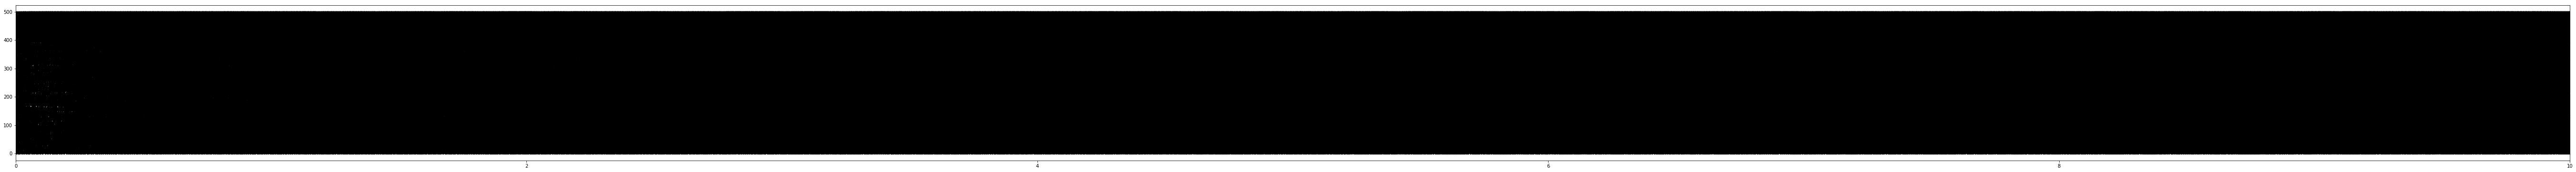

In [5]:
plt.figure( figsize = (96, 6) )
plt.plot( spike_monitor.t / b.second, spike_monitor.i, 'k.' )
plt.xlim( 0, 10 )

(119, 120)

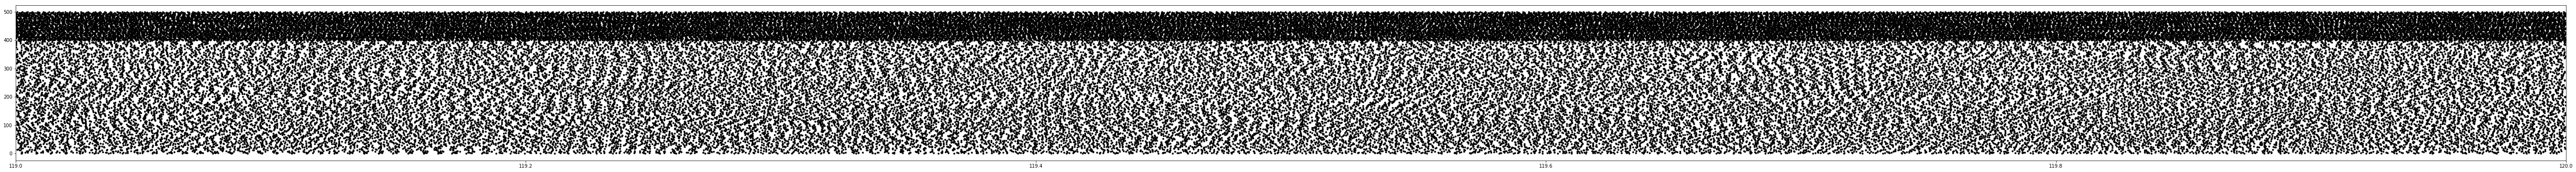

In [6]:
plt.figure( figsize = (96, 6) )
plt.plot( spike_monitor.t / b.second, spike_monitor.i, 'k.' )
plt.xlim( 119, 120 )

(239, 240)

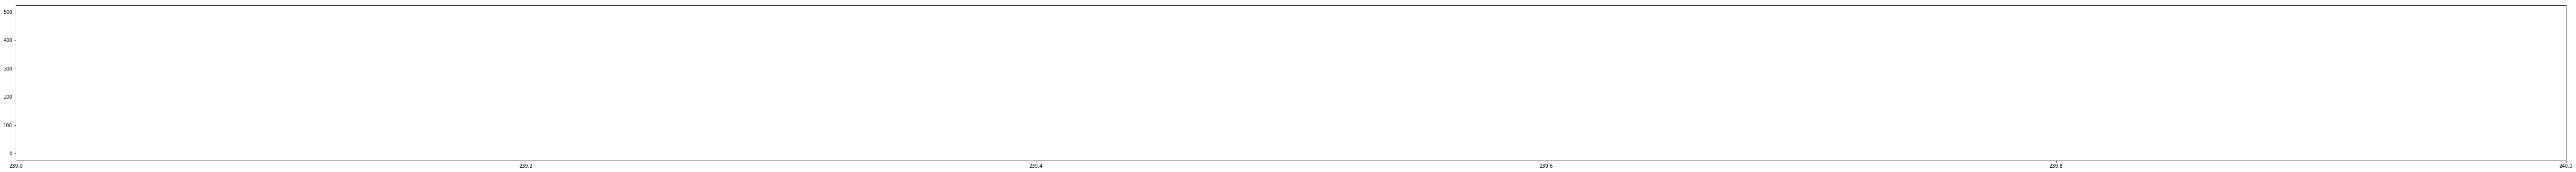

In [7]:
plt.figure( figsize = (96, 6) )
plt.plot( spike_monitor.t / b.second, spike_monitor.i, 'k.' )
plt.xlim( 239, 240 )

(0, 2)

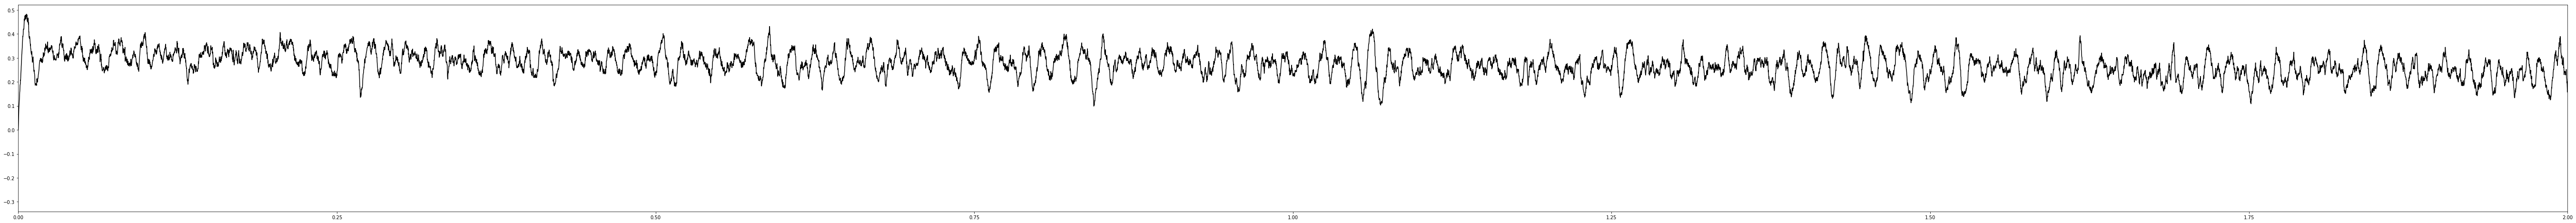

In [147]:
plt.figure( figsize = (96, 8) )
plt.plot( neuron_monitor.t / b.second, np.mean( neuron_monitor.v[:N, :], axis = 0 ), 'k-' )
plt.xlim( 0, 2 )

In [9]:
import scipy.signal

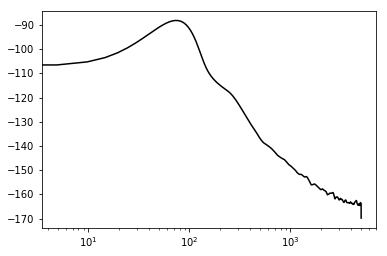

In [149]:
dt = (neuron_monitor.t[1] - neuron_monitor.t[0]) / b.second
f, Pxx = scipy.signal.welch( np.mean( neuron_monitor.v[:N, :], axis = 0 )[neuron_monitor.t / b.second > 15],
                             nfft = 2048,
                             fs = 1. / dt )
plt.semilogx( f, 20 * np.log10( Pxx ), 'k-' )

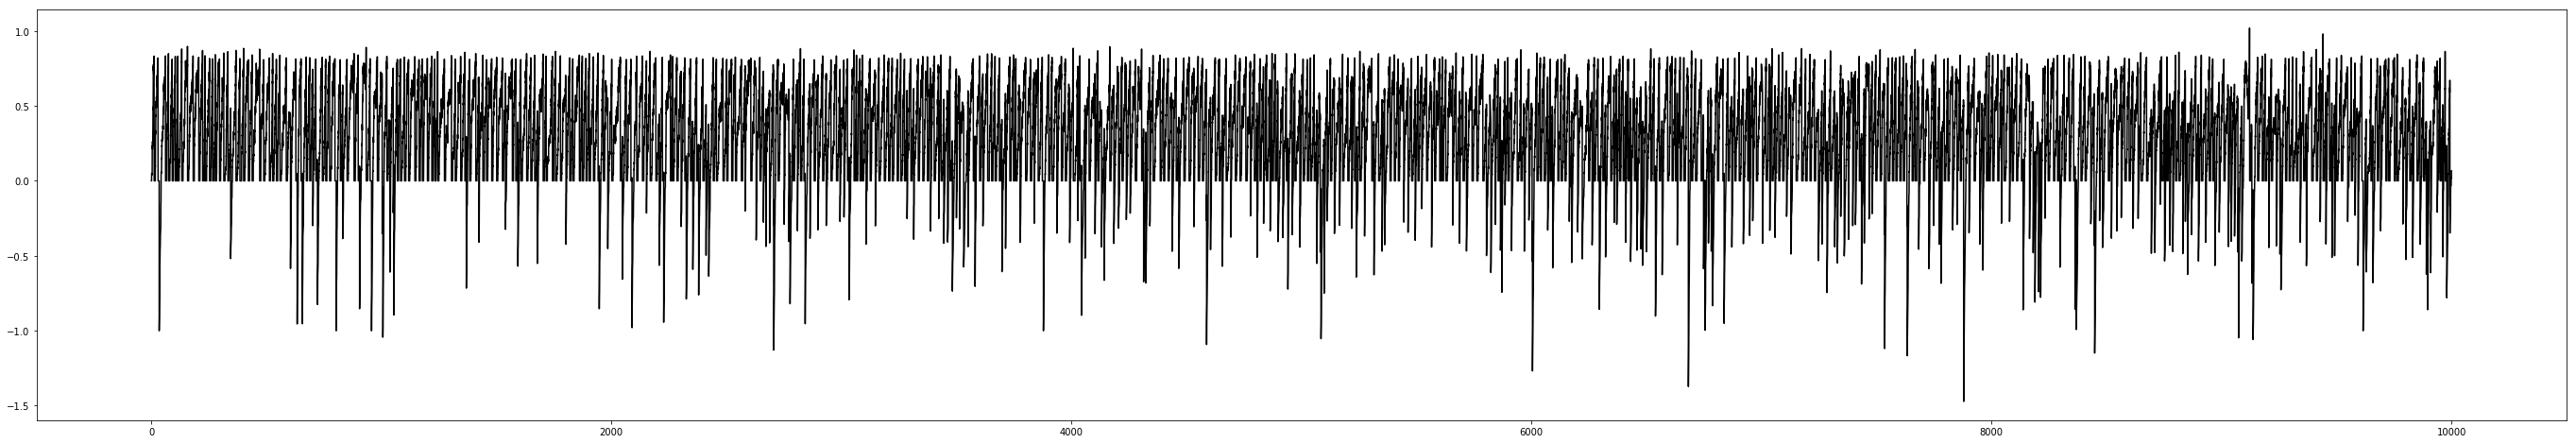

In [46]:
plt.figure( figsize = (48, 8) )
plt.plot( neuron_monitor.t / b.ms, neuron_monitor.v[1, :], 'k-' )

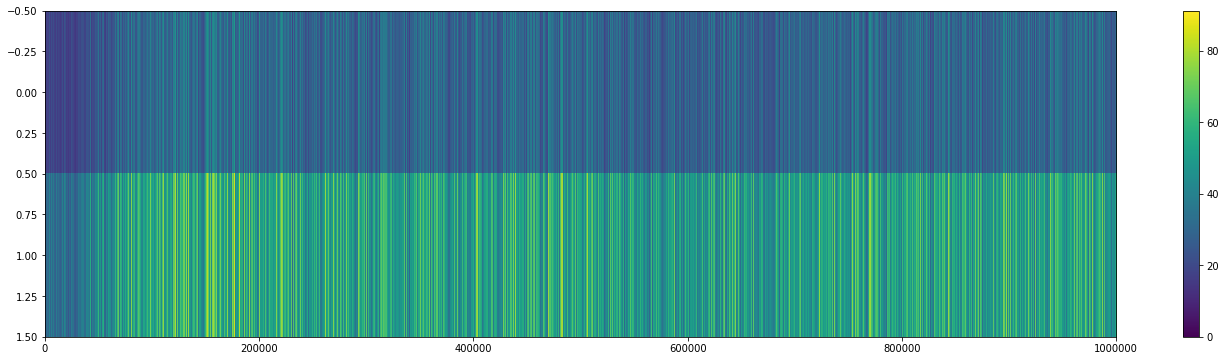

In [11]:
plt.figure( figsize = (24, 6) )
plt.imshow( astrocyte_monitor.a, aspect = 'auto' )
plt.colorbar()

MemoryError: Unable to allocate array with shape (1827, 1000000) and data type float64

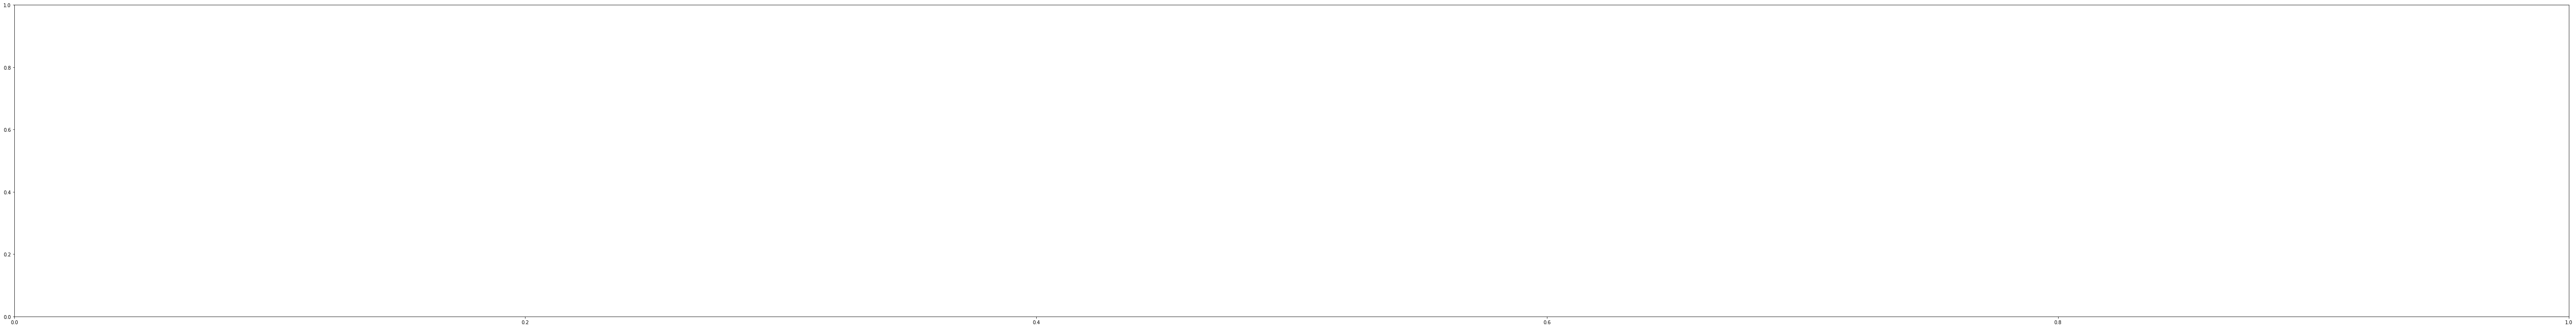

In [12]:
plt.figure( figsize = (96, 12) )
plt.imshow( weight_monitor_e.atotint, aspect = 'auto' )
plt.colorbar()

In [13]:
del weight_monitor_e

In [14]:
plt.plot( weight_monitor_e.t / b.second, weight_monitor_e.w[800, :], 'k-' )
plt.xlim( 90, 100 )

MemoryError: Unable to allocate array with shape (1216, 1000000) and data type float64

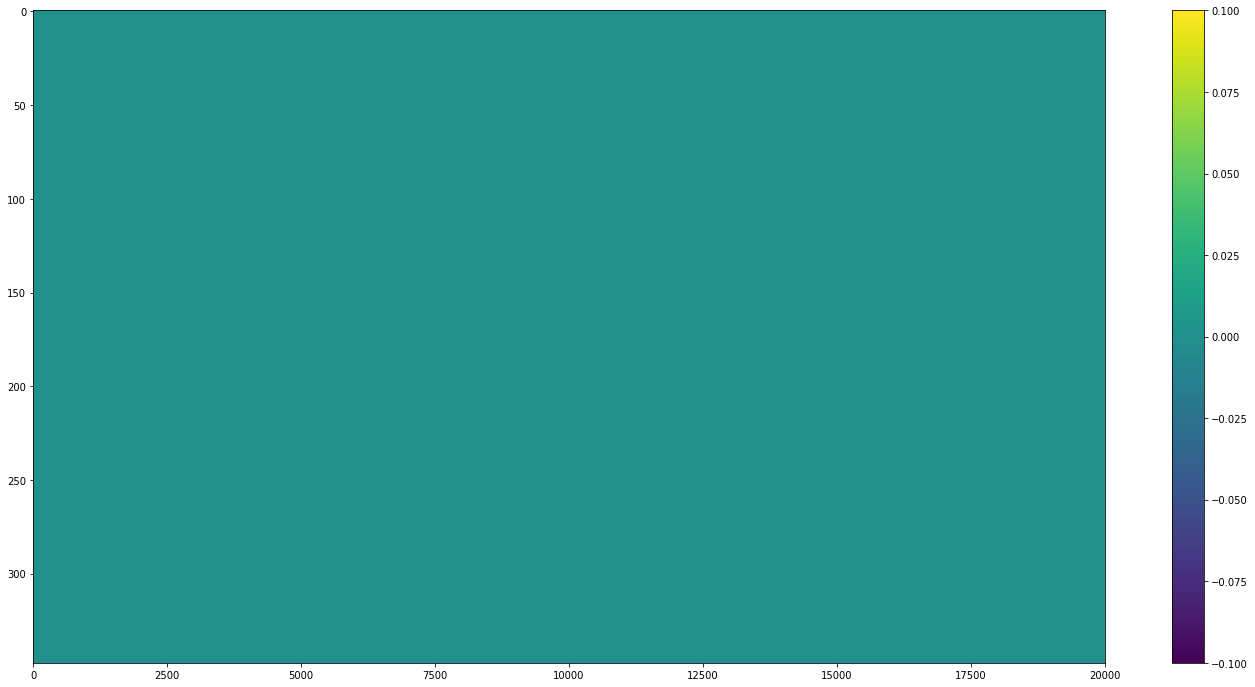

In [33]:
plt.figure( figsize = (24, 12) )
plt.imshow( weight_monitor_e.atot, aspect = 'auto' )
plt.colorbar()

In [14]:
import gc
gc.collect()
plt.clf()

<Figure size 432x288 with 0 Axes>

### Check for effects on power of astrocytes

In [27]:
synapse_input_betas = np.linspace( 0., 0.025, 100 )
result_Pxx = None

for i_beta, synapse_input_beta in enumerate( synapse_input_betas ):
    print( 'Run {0}, beta = {1}'.format( i_beta + 1, synapse_input_beta ) )
    
    b.restore()

    print( '    Running simulation...', end = '' )
    b.run( 2000 * b.ms )
    print( 'Done' )
    
    dt = (neuron_monitor.t[1] - neuron_monitor.t[0]) / b.second
    f, Pxx = scipy.signal.welch( np.mean( neuron_monitor.v, axis = 0 )[neuron_monitor.t / b.ms > 300], fs = 1. / dt )
    
    if result_Pxx is None:
        result_Pxx = np.zeros( (synapse_input_betas.shape[0], Pxx.shape[0]) )
    result_Pxx[i_beta, :] = Pxx

Run 1, beta = 0.0
    Running simulation...Done
Run 2, beta = 0.0002525252525252525
    Running simulation...Done
Run 3, beta = 0.000505050505050505
    Running simulation...Done
Run 4, beta = 0.0007575757575757576
    Running simulation...Done
Run 5, beta = 0.00101010101010101
    Running simulation...Done
Run 6, beta = 0.0012626262626262625
    Running simulation...Done
Run 7, beta = 0.0015151515151515152
    Running simulation...Done
Run 8, beta = 0.0017676767676767678
    Running simulation...Done
Run 9, beta = 0.00202020202020202
    Running simulation...Done
Run 10, beta = 0.0022727272727272726
    Running simulation...Done
Run 11, beta = 0.002525252525252525
    Running simulation...Done
Run 12, beta = 0.002777777777777778
    Running simulation...Done
Run 13, beta = 0.0030303030303030303
    Running simulation...Done
Run 14, beta = 0.0032828282828282827
    Running simulation...Done
Run 15, beta = 0.0035353535353535356
    Running simulation...Done
Run 16, beta = 0.003787878787

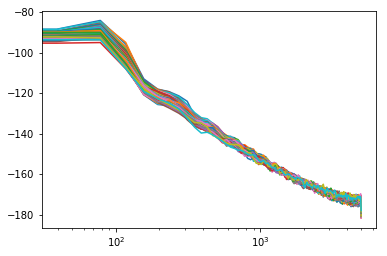

In [28]:
plt.semilogx( f, 20 * np.log10( result_Pxx ).T )
plt.show()

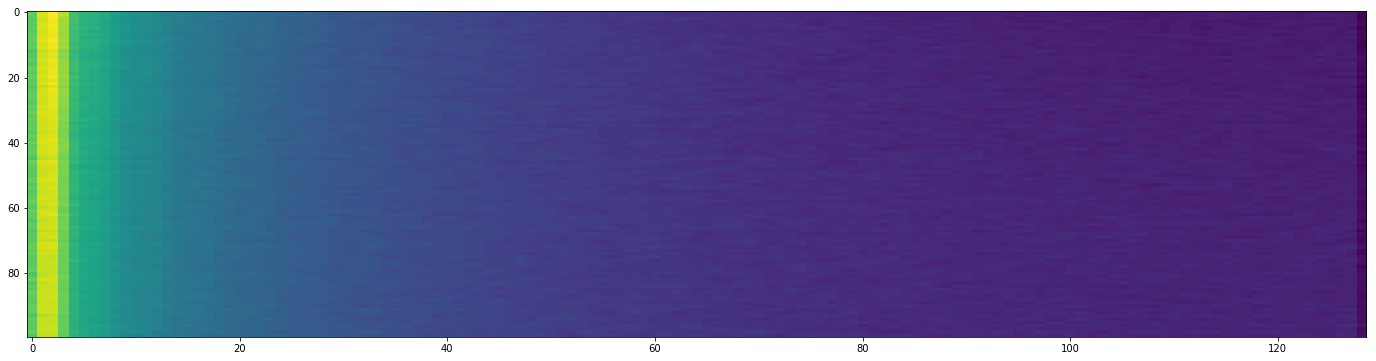

In [29]:
plt.figure( figsize = (24, 6) )
plt.imshow( np.log10( result_Pxx ), aspect = 'auto' )

In [30]:
result_Pxx_rel = np.zeros( result_Pxx.shape )
for i in range( result_Pxx.shape[0] ):
    result_Pxx_rel[i, :] = 20 * np.log10( result_Pxx[i, :] / result_Pxx[0, :] )

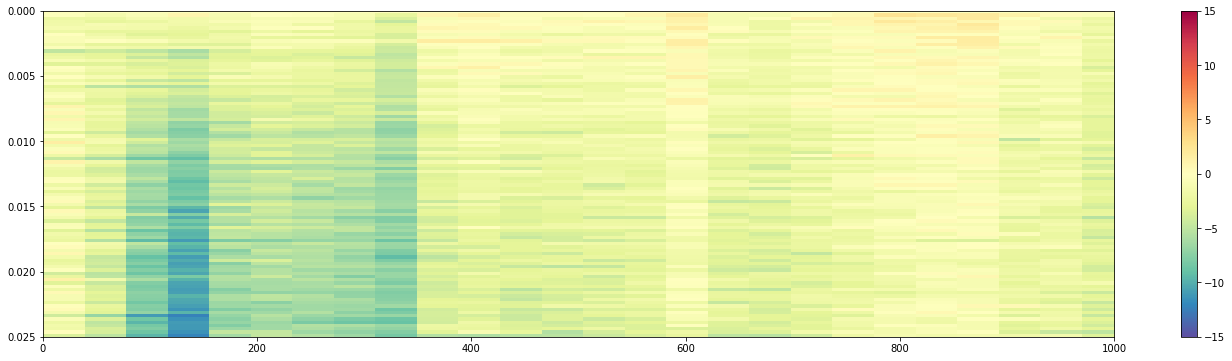

In [31]:
plt.figure( figsize = (24, 6) )
plt.imshow( result_Pxx_rel, aspect = 'auto', cmap = 'Spectral_r',
            extent = [f[0], f[-1], synapse_input_betas[-1], synapse_input_betas[0]] )
plt.clim( -15, 15 )
plt.xlim( 0, 1000 )
plt.colorbar()

### Check for polychronous groups

In [7]:
# Kill neuron state

#network.restore( 'post_stdp' )

w_input = 0
plasticity_on = 0

network.run( 1 * b.second )

network.store( 'post_reset' )

print( 'Done' )

Done


In [10]:
import itertools

In [8]:
setup_time = network.t

In [9]:
def find_group( anchors, delays, duration = 250 * b.ms, start_offset = 5 * b.ms, stim_duration = 1.0 * b.ms ):
    
    network.restore( 'post_reset' )
    
    # Time at which current neuron under inspection is
    # expected to fire
    t0 = np.max( np.array( delays ) ) * b.second + start_offset
    
    # Toggle simulation parameters
    w_input = 0.
    plasticity_on = 0
    neurons.v = np.zeros( (N + Ni,) )
    
    I_stim = 1000.
    input_dt = 0.1 * b.ms
#     I_array = np.zeros( (int( duration / input_dt ), (N + Ni)) )
#     for ni, ti in zip( anchors, delays ):
#         I_array[ni, :] = I_stim
# #         I_array[ni, int( np.round( t0 - ti ) )] = I_stim
#     neuron_input = b.TimedArray( np.array( I_array ), dt = input_dt )
#     neurons.namespace['neuron_input'] = neuron_input
    def update_inputs( t ):
        t_rel = t - setup_time
        neurons.I = 0
        for ni, di in zip( anchors, delays ):
            ti = t0 - di
            if np.abs( t_rel - ti ) <= (stim_duration / 2.):
                neurons.I[ni] = I_stim
#                 print( 'Stimming {0}'.format( ni ) )
    
    network_op = b.network_operation( update_inputs, dt = input_dt )
    network.add( network_op )
    
    network.run( start_offset + duration )
    
    network.remove( network_op )
    
    plt.imshow( neuron_monitor.v[:, neuron_monitor.t >= setup_time], aspect = 'auto' )
    plt.colorbar()
    plt.show()
    
    cur_t = spike_monitor.t[spike_monitor.t >= setup_time] - setup_time
    cur_i = spike_monitor.i[spike_monitor.t >= setup_time]
    
    return cur_t, cur_i

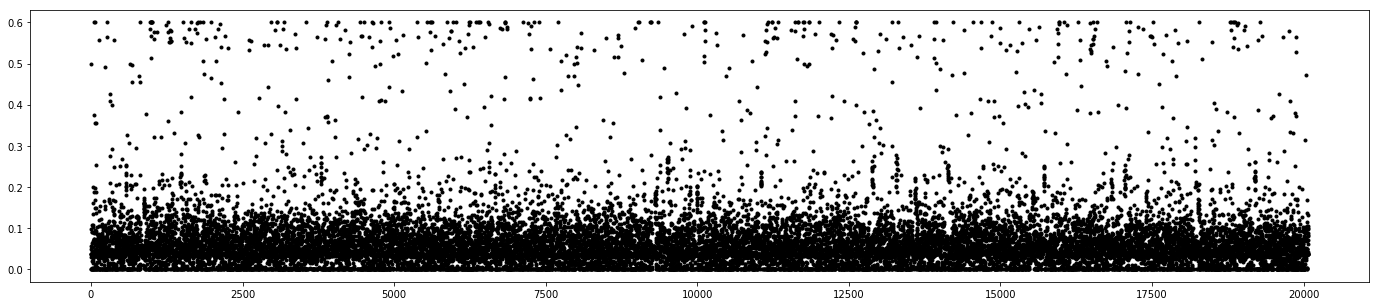

In [10]:
plt.figure( figsize = (24, 5) )
plt.plot( synapses_e.w[:], 'k.' )
plt.show()

In [11]:
strong_synapse_threshold = 0.7 * w_max
n_anchor = 4

for j_neuron in range( N ):
    print( 'Postsynaptic neuron {0}'.format( j_neuron ) )
    
    cur_synapses = np.where( synapses_e.j == j_neuron )[0]
    cur_strong_synapses = np.where( (synapses_e.j == j_neuron) & (synapses_e.w >= strong_synapse_threshold) )[0]
    # Presynaptic neurons of strong synapses are candidates for groups
    cur_candidates = synapses_e.i[cur_strong_synapses]
    cur_candidate_delays = synapses_e.delay[cur_strong_synapses]
    print( '    Candidate presynaptic neurons: {0}'.format( cur_candidates ) )

    if len( cur_candidates ) < n_anchor:
        print( '    Not enough candidate neurons to anchor' )
        continue
    
    print( '    Testing anchor combinations...' )
    for cur_anchor_delay in itertools.combinations( zip( cur_candidates, cur_candidate_delays ), n_anchor ):
        # Separate out our combination, which is a list of (anchor, delay)
        cur_anchors, cur_delays = zip( *cur_anchor_delay )
        print( '        {0} @ {1}'.format( cur_anchors, cur_delays ) )
        
        cur_t, cur_i = find_group( cur_anchors, cur_delays )
        
        plt.figure( figsize = (12, 4) )
        plt.plot( cur_t / b.ms, cur_i, 'k.' )
        plt.show()

Postsynaptic neuron 0
    Candidate presynaptic neurons: [136]
    Not enough candidate neurons to anchor
Postsynaptic neuron 1
    Candidate presynaptic neurons: [221]
    Not enough candidate neurons to anchor
Postsynaptic neuron 2
    Candidate presynaptic neurons: []
    Not enough candidate neurons to anchor
Postsynaptic neuron 3
    Candidate presynaptic neurons: [4]
    Not enough candidate neurons to anchor
Postsynaptic neuron 4
    Candidate presynaptic neurons: [279]
    Not enough candidate neurons to anchor
Postsynaptic neuron 5
    Candidate presynaptic neurons: [330]
    Not enough candidate neurons to anchor
Postsynaptic neuron 6
    Candidate presynaptic neurons: [35]
    Not enough candidate neurons to anchor
Postsynaptic neuron 7
    Candidate presynaptic neurons: []
    Not enough candidate neurons to anchor
Postsynaptic neuron 8
    Candidate presynaptic neurons: [126]
    Not enough candidate neurons to anchor
Postsynaptic neuron 9
    Candidate presynaptic neurons

In [ ]:
# synapse_input_beta = 0. #1. # 10.
# w_i = -0.2
# w_max = 0.4
plasticity_on = 0

print( 'Running simulation...', end = '' )
b.run( 200 * b.ms )
print( 'Done' )

## Astrocytes with multiple regions

In [15]:
b.start_scope()

Nx = 10
Ny = 10

N = Nx * Ny
Na = N // 2

regions = ['region_1', 'region_2']
n_regions = len( regions )

print( 'Setting up input...', end = '' )
N_input = 1000
input_freq = 40 * b.Hz
inputs = b.PoissonGroup( n_regions * N_input, input_freq )
inputs_region = { region: inputs[(i_region * N_input):((i_region+1) * N_input)]
                  for i_region, region in enumerate( regions ) }
print( 'Done' )

print( 'Setting up neurons...', end = '' )

tau_membrane = 10 * b.ms # 10
neuron_spacing = 50 * b.um
total_width = neuron_spacing * Nx
total_height = neuron_spacing * Ny
equations = '''
dv/dt = (I - v) / tau_membrane : 1 (unless refractory)
I : 1
x : meter
y : meter
i_region : integer
'''
neurons = b.NeuronGroup( n_regions * N, equations,
                         threshold = 'v > 0.8',
                         reset = 'v = 0',
                         refractory = 5 * b.ms,
                         method = 'rk4' )
# neurons.I = np.random.exponential( size = (N,) ) * 2.
neurons.I = 0
neurons_region = { region: neurons[(i_region * N):((i_region+1) * N)]
                   for i_region, region in enumerate( regions ) }
for i_region, region in enumerate( regions ):
    for i_x in range( Nx ):
        for i_y in range( Ny ):
            i_cur = i_x + (i_y * Ny)
            neurons_region[region].x[i_cur] = neuron_spacing * i_x
            neurons_region[region].y[i_cur] = neuron_spacing * i_y
            neurons_region[region].i_region[i_cur] = i_region

print( 'Done' )

print( 'Setting up input connectivity...' )
w_input = 0.05
p_input = 0.05
input_synapses_region = dict()
for region in regions:
    print( '    Region {0}'.format( region ) )
    input_synapses_region[region] = b.Synapses( inputs_region[region], neurons_region[region],
                                                on_pre = 'v_post += w_input' )
    input_synapses_region[region].connect( p = p_input )
print( 'Done' )

print( 'Setting up astrocytes...', end = '' )
        
tau_mean_field = 100 * b.ms
tau_astrocyte = 100 * b.ms
astrocyte_equations = '''
abar : 1
da/dt = ((abar - a) / tau_mean_field) - (a / tau_astrocyte) : 1
x : meter
y : meter
i_region : integer
'''
astrocytes = b.NeuronGroup( n_regions * Na, astrocyte_equations,
                            method = 'rk4' )
astrocytes_region = { region: astrocytes[(i_region * Na):((i_region+1) * Na)]
                      for i_region, region in enumerate( regions ) }
astrocytes.x = np.random.rand( n_regions * Na ) * total_width
astrocytes.y = np.random.rand( n_regions * Na ) * total_height
for i_region, region in enumerate( regions ):
    for i in range( Na ):
        astrocytes_region[region].i_region[i] = i_region

print( 'Done' )

print( 'Setting up astrocyte syncytium...', end = '' )
syncytium_equations = '''
abar_post = (1 / (n_regions * Na)) * a_pre (summed)
'''
syncytium = b.Synapses( astrocytes, astrocytes )
syncytium.connect()
print( 'Done' )

print( 'Setting up synapses...' )

synapse_connect_p = np.array( [[0.2, 0.05], [0.05, 0.2]] )
synapse_r_max = 25 * b.um
tau_astro_synapse = 100 * b.ms
tau_pre_synapse = 20 * b.ms
tau_post_synapse = 20 * b.ms
w_max = 0.1
Apre = -0.01
Apost = -Apre * ( tau_pre_synapse / tau_post_synapse ) * 0.95 # 1.05
synapse_equations = '''
atot : 1
dw/dt = (-atot * w) / tau_astro_synapse : 1
dapre/dt = -apre / tau_pre_synapse : 1 (event-driven)
dapost/dt = -apost / tau_post_synapse : 1 (event-driven)
x_syn : meter
y_syn : meter
i_ast : integer
i_region_syn : integer
'''
synapse_on_pre = '''
v_post += w
apre += Apre
w = clip( w + apost, 0, w_max)
'''
synapse_on_post = '''
apost += Apost
w = clip( w + apre, 0, w_max)
'''
synapses = b.Synapses( neurons, neurons, synapse_equations,
                       on_pre = synapse_on_pre,
                       on_post = synapse_on_post,
                       method = 'rk4' )

for i_region_loop, pre_region in enumerate( regions ):
    for j_region_loop, post_region in enumerate( regions ):
        print( '    Connecting {0} -> {1}'.format( pre_region, post_region ) )
#         synapses.connect( condition = '(i >= i_region_loop * N) and (i < (i_region_loop+1) * N) and (j >= j_region_loop * N) and (j < (j_region_loop+1) * N)',
#                           p = synapse_connect_p[i_region_loop, j_region_loop] )
        for i in range( i_region_loop * N, (i_region_loop+1) * N ):
            if i > 0 and i % 10 == 0:
                print( '        From neuron {0}'.format( i ) )
            for j in range( j_region_loop * N, (j_region_loop+1) * N ):
                if i == j:
                    continue
                synapses.connect( i = i, j = j, p = synapse_connect_p[i_region_loop, j_region_loop] )
synapses.w = w_max

astrocyte_pre_neurons = [ [] for i_ast in range( n_regions * Na ) ]
astrocyte_synapses = [ [] for i_ast in range( n_regions * Na ) ]
for i_synapse, pre_neuron in enumerate( synapses.i ):
    if i_synapse > 0 and i_synapse % 100 == 0:
        print( '    Prepping synapse {0}'.format( i_synapse ) )
    
    r_cur = synapse_r_max * np.random.rand()
    theta_cur = 2 * np.pi * np.random.rand()
    cur_x_syn = synapses.x_post[i_synapse] + r_cur * np.cos( theta_cur )
    cur_y_syn = synapses.y_post[i_synapse] + r_cur * np.sin( theta_cur )
    synapses.x_syn[i_synapse] = cur_x_syn
    synapses.y_syn[i_synapse] = cur_y_syn
    v_cur = np.array( [cur_x_syn, cur_y_syn] )
    
    cur_i_region_syn = synapses.i_region_post[i_synapse]
    synapses.i_region_syn[i_synapse] = cur_i_region_syn
    
    astrocyte_distances = np.zeros( (Na,) )
    for i_ast in range( Na ):
        v_ast = np.array( [astrocytes_region[regions[cur_i_region_syn]].x[i_ast],
                           astrocytes_region[regions[cur_i_region_syn]].y[i_ast]] )
        astrocyte_distances[i_ast] = np.linalg.norm( v_ast - v_cur )
    cur_i_ast_in_region = np.argmin( astrocyte_distances )
    cur_i_ast = (cur_i_region_syn * Na) + cur_i_ast_in_region
    synapses.i_ast[i_synapse] = cur_i_ast
    
    astrocyte_pre_neurons[cur_i_ast].append( pre_neuron )
    astrocyte_synapses[cur_i_ast].append( i_synapse )

print( 'Done' )

print( 'Setting up presynaptic neuron -> astrocycte connections...', end = '' )
    
astro_input_phi = 0.05
astro_input_equations = '''
phi = astro_input_phi : 1
'''
astro_input_on_pre = '''
a_post += phi
'''
astro_input = b.Synapses( neurons, astrocytes, astro_input_equations,
                          on_pre = astro_input_on_pre,
                          method = 'rk4' )
for i_ast, pre_neurons in enumerate( astrocyte_pre_neurons ):
    for pre_neuron in pre_neurons:
        astro_input.connect( i = pre_neuron, j = i_ast )

print( 'Done' )

print( 'Setting up astrocyte -> synapse connections...', end = '' )

synapse_input_beta = 0. # 0.02
synapse_input_equations = '''
beta = synapse_input_beta : 1
atot_post = beta * a_pre : 1 (summed)
'''
synapse_input = b.Synapses( astrocytes, synapses, synapse_input_equations,
                            method = 'rk4' )
for i_ast, ast_synapses in enumerate( astrocyte_synapses ):
    for ast_synapse in ast_synapses:
        synapse_input.connect( i = i_ast, j = ast_synapse )

print( 'Done' )

neuron_monitor = b.StateMonitor( neurons, 'v', record = True )
astrocyte_monitor = b.StateMonitor( astrocytes, 'a', record = True )
weight_monitor = b.StateMonitor( synapses, ['w', 'atot'], record = True )
spike_monitor = b.SpikeMonitor( neurons )

b.store()

Setting up input...Done
Setting up neurons...Done
Setting up input connectivity...
    Region region_1
    Region region_2
Done
Setting up astrocytes...Done
Setting up astrocyte syncytium...Done
Setting up synapses...
    Connecting region_1 -> region_1
        From neuron 10
        From neuron 20
        From neuron 30
        From neuron 40
        From neuron 50
        From neuron 60
        From neuron 70
        From neuron 80
        From neuron 90
    Connecting region_1 -> region_2
        From neuron 10
        From neuron 20
        From neuron 30
        From neuron 40
        From neuron 50
        From neuron 60
        From neuron 70
        From neuron 80
        From neuron 90
    Connecting region_2 -> region_1
        From neuron 100
        From neuron 110
        From neuron 120
        From neuron 130
        From neuron 140
        From neuron 150
        From neuron 160
        From neuron 170
        From neuron 180
        From neuron 190
    Connecting regio

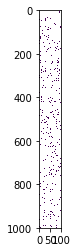

In [29]:
W = np.full( (len( inputs_region['region_1'] ), len( neurons_region['region_1'] )), np.nan )
W[input_synapses_region['region_1'].i[:], input_synapses_region['region_1'].j[:]] = 1. #input_synapses_region['region_1'].w[:]
plt.imshow( W )

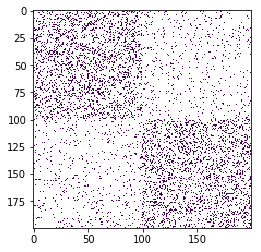

In [16]:
W = np.full( (len( neurons ), len( neurons )), np.nan )
W[synapses.i[:], synapses.j[:]] = synapses.w[:]
plt.imshow( W )

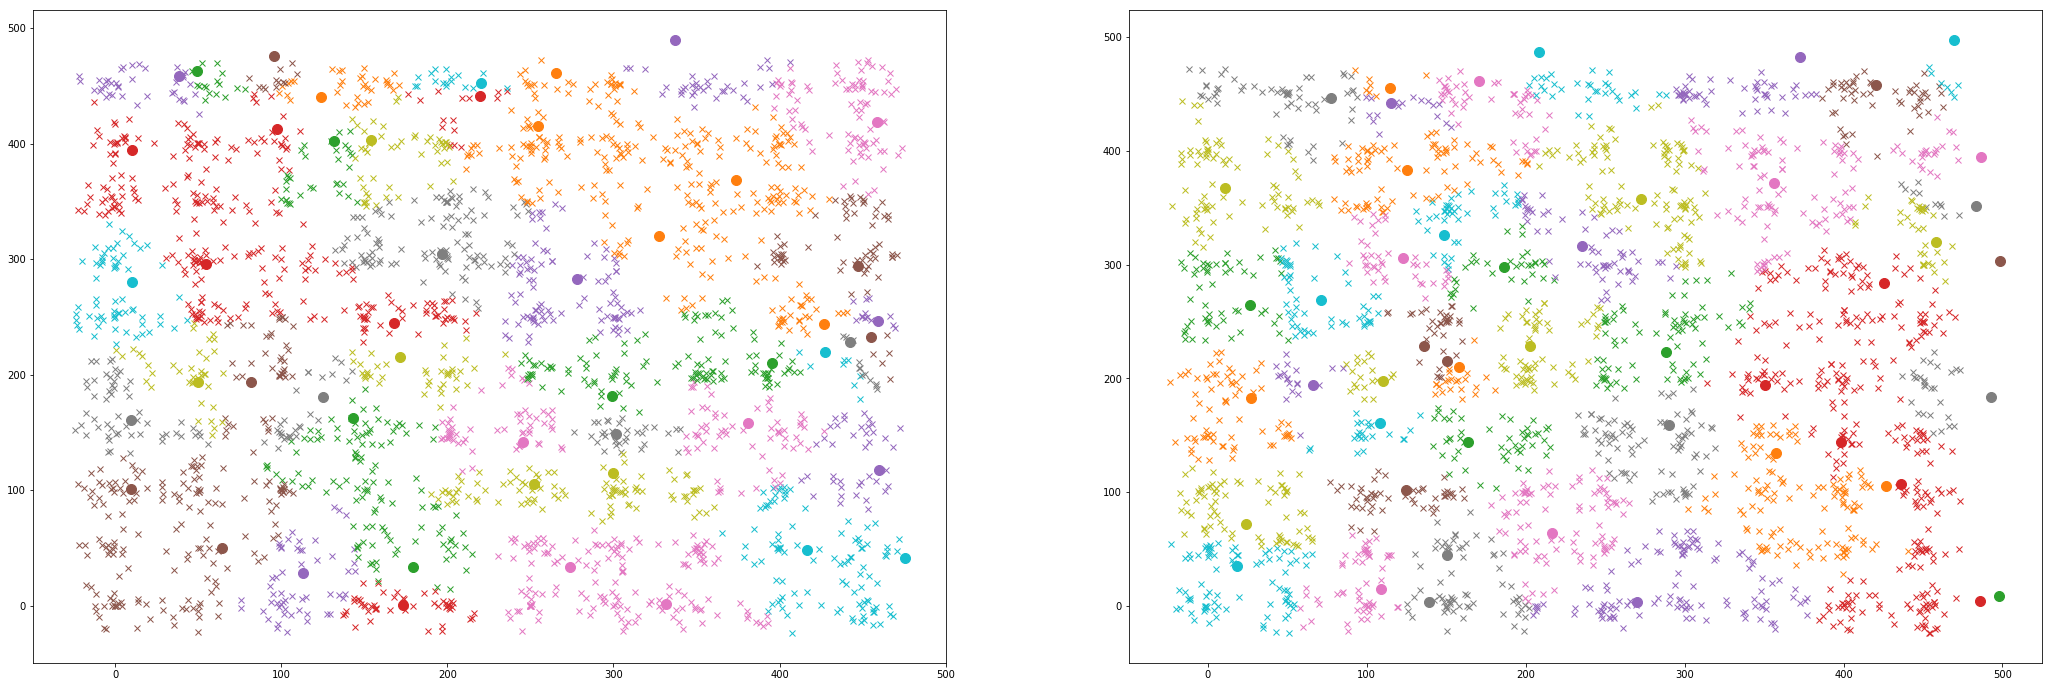

In [17]:
fig, axs = plt.subplots( 1, n_regions, figsize = (36, 12) )

for i_region, region in enumerate( regions ):
    for i_ast_in_region in range( Na ):
        i_ast = (i_region * Na) + i_ast_in_region
        cur_synapses = synapses.i_ast == i_ast
        for i_synapse in range( synapses.i_ast.shape[0] ):
            if cur_synapses[i_synapse]:
                axs[i_region].plot( synapses.x_syn[i_synapse] / b.um, synapses.y_syn[i_synapse] / b.um, 'C{0}x'.format( i_ast % 9 + 1 ) )
        axs[i_region].plot( astrocytes.x[i_ast] / b.um, astrocytes.y[i_ast] / b.um, 'C{0}.'.format( i_ast % 9 + 1 ), markersize = 20 )

In [18]:
b.restore()

synapse_input_beta = 0.02

print( 'Running simulation...', end = '' )
b.run( 2000 * b.ms )
print( 'Done' )

Running simulation...Done


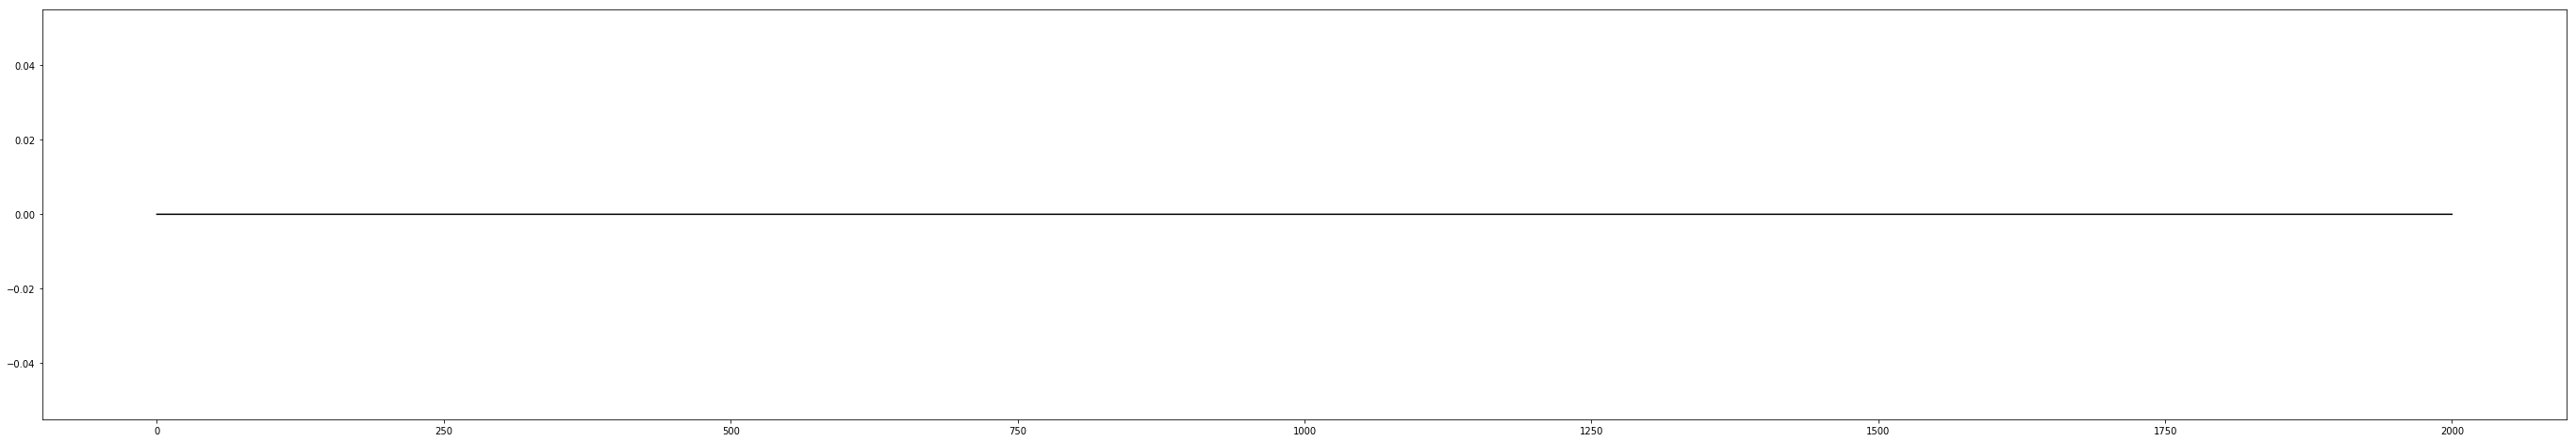

In [22]:
plt.figure( figsize = (48, 8) )
plt.plot( neuron_monitor.t / b.ms, neuron_monitor.v[2, :], 'k-' )

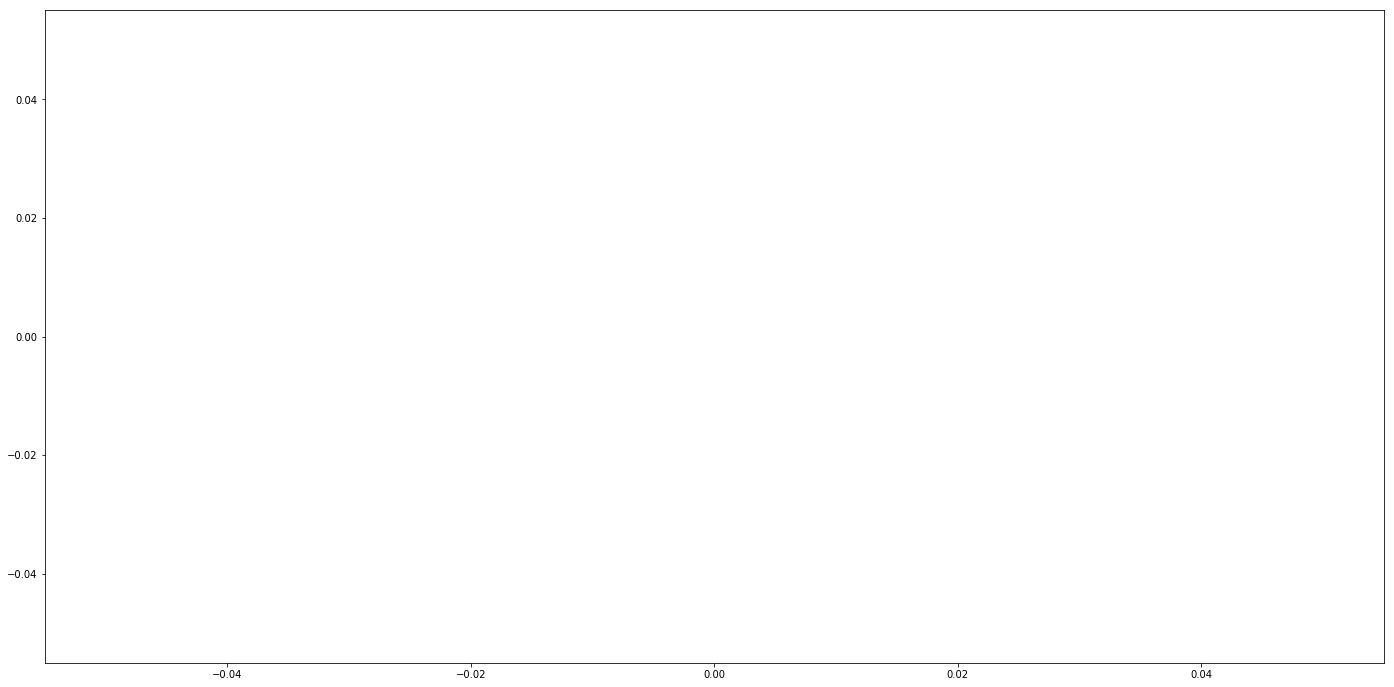

In [19]:
plt.figure( figsize = (24, 12) )
plt.plot( spike_monitor.t / b.ms, spike_monitor.i, 'k.' )
# plt.xlim( 1400, 1600 )